# Telco Customer Churn Prediction
### Oleh: Suluh Bagaspati

## Business Problem Understanding

### Context
Perusahaan telekomunikasi memiliki model bisnis berbasis subscription (pelanggan membayar secara berkala untuk menggunakan layanan). Salah satu tantangan utama dalam industri ini adalah churn, yaitu pelanggan memutuskan untuk berhenti berlangganan dan pindah ke kompetitor. Setiap kali churn terjadi:
1. Perusahaan kehilangan pendapatan bulanan dari pelanggan tersebut.
2. Biaya akuisisi pelanggan baru jauh lebih tinggi dibandingkan mempertahankan pelanggan lama. [Artikel ilmiah](https://pmc.ncbi.nlm.nih.gov/articles/PMC10239051/?utm_source=chatgpt.com) menyebutkan bahwa mendapatkan pelanggan baru bisa 5–25 kali lebih mahal dibanding mempertahankan pelanggan yang sudah ada.
3. Loyalitas merek menurun yang berpotensi memicu lebih banyak churn.

### Problem Statement
Perusahaan belum memiliki sistem prediksi dini untuk mengidentifikasi pelanggan yang berisiko churn sehingga banyak pelanggan hilang tanpa adanya upaya retensi yang tepat waktu. Hal ini mengurangi peluang untuk mempertahankan pelanggan yang sebenarnya dapat diselamatkan dengan intervensi yang tepat.

### Goals
Membangun model prediksi churn berbasis machine learning sehingga perusahaan dapat mendeteksi pelanggan berisiko tinggi sebelum mereka meninggalkan layanan.

### Stakeholder
- Divisi Customer Retention/CRM: akan menggunakan hasil model untuk menargetkan pelanggan berisiko tinggi churn dengan promosi atau penawaran khusus.
- Tim Marketing: menyusun kampanye berdasarkan segmen pelanggan yang rawan churn.

### Analytic Approach
Analisis dilakukan untuk mengetahui fitur-fitur yang berpengaruh terhadap keputusan pelanggan untuk berhenti berlangganan. Kemudian, model klasifikasi dengan machine learning dibangun dengan fitur-fitur yang telah dipilih untuk memprediksi kemungkinan pelanggan yang berhenti berlangganan.

### Metric Evaluation
Fokus utama yaitu pelanggan yang berisiko churn sehingga targetnya:
- 0 = Pelanggan yang tidak churn
- 1 = Pelanggan yang churn

Berdasarkan target didapati dua jenis error:
- False Positive (FP)
  - Model memprediksi pelanggan akan churn padahal sebenarnya tidak churn.
  - Konsekuensi: Kerugian finansial dari over-treatment pelanggan karena penggunaan biaya retensi yang tidak tepat.
- False Negative (FN)
  - Model memprediksi pelanggan tidak churn padahal sebenarnya churn.
  - Konsekuensi: Kerugian pendapatan langsung dari pelanggan yang pergi ditambah biaya penggantian pelanggan yang tinggi.

Dari konsekuensi dari kedua error didapati:
- FN lebih berbahaya secara finansial dibanding FP karena setiap pelanggan churn yang terlewat berarti kehilangan pendapatan dan membutuhkan biaya besar mencari penggantinya.
- Oleh karena itu, fokus terhadap Recall yang mengurangi FN jadi prioritas utama meskipun bisa menaikkan FP.
- FP masih bisa diterima sampai batas tertentu terutama jika biaya retensi per pelanggan jauh lebih rendah dibanding kehilangan pelanggan.

## Data Understanding
- Dataset source: https://drive.google.com/drive/folders/1_fR7R0srpZgnFnanbrmELgnK-xmzMAHp
- Tidak ada informasi mengenai pembuat dan tanggal pembuatan dataset.
- Setiap baris merepresentasikan pelanggan perusahaan.

### Attribute Information
| Feature           | Description                                                   |
|-------------------|---------------------------------------------------------------|
| Dependents        | Whether the customer has dependents or not.                   |
| Tenure            | Number of months the customer has stayed with the company.    |
| OnlineSecurity    | Whether the customer has online security or not.              |
| OnlineBackup      | Whether the customer has online backup or not.                |
| InternetService   | Whether the client is subscribed to Internet service.         |
| DeviceProtection  | Whether the client has device protection or not.              |
| TechSupport       | Whether the client has tech support or not.                   |
| Contract          | Type of contract according to duration.                       |
| PaperlessBilling  | Bills issued in paperless form.                               |
| MonthlyCharges    | Amount of charge for service on monthly bases.                |
| Churn             | Whether the customer churns or not.                           |


## Data Cleaning

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Image
from scipy.stats import normaltest, chi2_contingency

# Feature Engineering
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Model Selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

# Imbalance Dataset
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Ignore Warning
import warnings
warnings.filterwarnings('ignore')
    
import pickle

### Load Dataset

In [2]:
df = pd.read_csv('data_telco_customer_churn.csv')
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


### Pengecekan Duplikat

In [3]:
print('Jumlah duplikat baris:', df.duplicated().sum())

Jumlah duplikat baris: 77


Menghapus duplikat agar model tidak bias ke data yang duplikat.

In [4]:
df = df.drop_duplicates().reset_index(drop=True)
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


In [5]:
print('Jumlah duplikat baris:', df.duplicated().sum())

Jumlah duplikat baris: 0


### Pengecekan Missing Value dan Nilai Unik

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4853 entries, 0 to 4852
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4853 non-null   object 
 1   tenure            4853 non-null   int64  
 2   OnlineSecurity    4853 non-null   object 
 3   OnlineBackup      4853 non-null   object 
 4   InternetService   4853 non-null   object 
 5   DeviceProtection  4853 non-null   object 
 6   TechSupport       4853 non-null   object 
 7   Contract          4853 non-null   object 
 8   PaperlessBilling  4853 non-null   object 
 9   MonthlyCharges    4853 non-null   float64
 10  Churn             4853 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 417.2+ KB


In [7]:
display(df.describe(),df.describe(include=['object']))

,tenure,MonthlyCharges
count,4853.000000,4853.000000
mean,32.679992,65.321543
std,24.395554,29.783655
min,0.000000,18.800000
25%,9.000000,40.050000
50%,29.000000,70.600000
75%,56.000000,90.050000
max,72.000000,118.650000


,Dependents,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,Churn
count,4853,4853,4853,4853,4853,4853,4853,4853,4853
unique,2,3,3,3,3,3,3,2,2
top,No,No,No,Fiber optic,No,No,Month-to-month,Yes,No
freq,3380,2420,2148,2154,2162,2442,2665,2925,3565


In [8]:
dataDesc = []
for i in df.columns:
    dataDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((df[i].isna().sum() /len(df)) *100,2),
        df[i].nunique(),
        df[i].unique()
    ])

pd.set_option('max_colwidth', None)

pd.DataFrame(dataDesc, columns=[
    'Data Features',
    'Data Types',
    'Null Val',
    'Null Percentage',
    'Unique',
    'Unique Sample'
])

,Data Features,Data Types,Null Val,Null Percentage,Unique,Unique Sample
0,Dependents,object,0,0.0,2,"[Yes, No]"
1,tenure,int64,0,0.0,73,"[9, 14, 64, 72, 3, 40, 17, 11, 8, 47, 18, 5, 1, 48, 13, 58, 7, 4, 70, 34, 31, 37, 15, 71, 10, 43, 22, 33, 69, 54, 63, 55, 66, 56, 32, 26, 24, 2, 51, 23, 49, 28, 36, 45, 42, 6, 61, 59, 67, 65, 0, 16, 52, 41, 25, 62, 20, 50, 30, 60, 19, 35, 57, 27, 44, 53, 12, 46, 39, 29, 38, 68, 21]"
2,OnlineSecurity,object,0,0.0,3,"[No, Yes, No internet service]"
3,OnlineBackup,object,0,0.0,3,"[No, Yes, No internet service]"
4,InternetService,object,0,0.0,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,object,0,0.0,3,"[Yes, No internet service, No]"
6,TechSupport,object,0,0.0,3,"[Yes, No, No internet service]"
7,Contract,object,0,0.0,3,"[Month-to-month, Two year, One year]"
8,PaperlessBilling,object,0,0.0,2,"[Yes, No]"
9,MonthlyCharges,float64,0,0.0,1422,"[72.9, 82.65, 47.85, 69.65, 23.6, 74.55, 19.7, 44.05, 73.5, 40.3, 33.6, 96.25, 70.45, 30.55, 44.8, 20.0, 81.5, 94.35, 35.3, 50.7, 106.05, 56.3, 20.65, 98.9, 40.2, 81.2, 19.45, 116.1, 55.2, 94.45, 84.85, 19.6, 79.0, 74.7, 30.4, 55.8, 104.5, 70.55, 55.25, 96.65, 88.85, 109.25, 104.75, 74.4, 79.4, 74.1, 73.05, 94.6, 70.35, 79.6, 79.5, 90.7, 81.0, 87.75, 118.65, 24.8, 105.25, 57.8, 19.0, 25.7, 54.2, 44.85, 19.95, 81.05, 20.35, 85.25, 67.45, 100.3, 20.95, 105.2, 26.35, 82.15, 102.6, 106.15, 23.95, 115.8, 66.85, 90.35, 89.85, 73.35, 104.45, 35.45, 88.4, 70.5, 25.1, 39.0, 83.25, 74.3, 54.3, 50.45, 86.0, 19.55, 103.5, 91.7, 64.85, 99.65, 68.75, 106.25, 75.9, 94.4, ...]"


Tidak ditemui kolom yang memiliki nilai kosong.

### Pengecekan Outlier

In [9]:
numeric_cols_var = ['tenure', 'MonthlyCharges']

for col in numeric_cols_var:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    batas_bawah = Q1 - 1.5 * IQR
    batas_atas  = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < batas_bawah) | (df[col] > batas_atas)]

    persentase =  round((len(outliers)/len(df)) *100,4)
    
    print(f'Persentase jumlah outlier kolom {col}: {persentase}%')

Persentase jumlah outlier kolom tenure: 0.0%
Persentase jumlah outlier kolom MonthlyCharges: 0.0%


Tidak ada outlier pada fitur numerik.

### Data Transformation

In [10]:
InternetService_Yes = df[df['InternetService']!='No']
InternetService_No = df[df['InternetService']=='No']

dataDesc = []
for i in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']:
    dataDesc.append([
        i,
        InternetService_Yes[i].unique(),
        InternetService_No[i].unique()
    ])

pd.set_option('max_colwidth', None)

pd.DataFrame(dataDesc, columns=[
    'Data Features',
    'Using Internet Service',
    'No Internet Service'
])

,Data Features,Using Internet Service,No Internet Service
0,OnlineSecurity,"[No, Yes]",[No internet service]
1,OnlineBackup,"[No, Yes]",[No internet service]
2,DeviceProtection,"[Yes, No]",[No internet service]
3,TechSupport,"[Yes, No]",[No internet service]


- Jika InternetService nilainya "No" maka kolom OnlineSecurity, OnlineBackup, DeviceProtection, dan TechSupport nilainya "No internet service".
- Jadi nilai "No internet service" bukan informasi baru melainkan hanya pengulangan dari fakta bahwa pelanggan tidak berlangganan Internet.

In [11]:
cols_to_replace = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']

df[cols_to_replace] = df[cols_to_replace].replace('No internet service', 'No')

- Dilakukan penggabungan nilai "No internet service" dan "No" pada empat kolom tersebut sehingga nilainya menjadi "No" saja.
- Alasan penggabungan:
  1. Mengurangi kategori dari 3 nilai (Yes / No / No internet service) jadi 2 nilai (Yes / No) sehingga model lebih sederhana.
  2. Menghindari redundancy.
  3. Memperkuat interpretasi artinya model hanya melihat apakah pelanggan punya fitur itu atau tidak tanpa mempedulikan alasan teknisnya.
  4. Mengurangi risiko multicollinearity sehingga hubungan antar variabel jadi lebih bersih.

## Feature Selection

### Pengecekan Imbalance Target

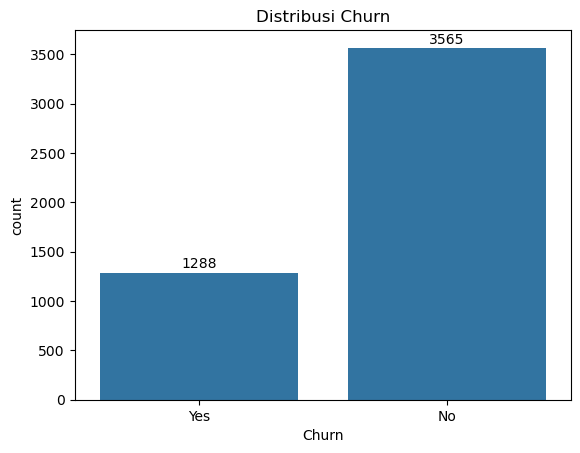

In [12]:
ax = sns.countplot(x=df['Churn'])
for container in ax.containers:
    ax.bar_label(container, padding=1)
plt.title('Distribusi Churn')
plt.show()

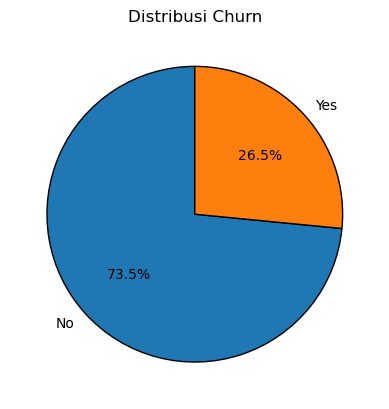

In [13]:
churn_counts = df['Churn'].value_counts()

plt.pie(churn_counts,
        labels=churn_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'black'})
plt.title('Distribusi Churn')
plt.show()

Dari bar chart dan pie chart diatas didapati distribusi churn Yes = 26.5% dan No = 73.5% artinya datanya tidak seimbang (imbalanced class).

### Pengecekan Features

In [14]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

Pengubahan Yes menjadi 1 dan No menjadi 0 untuk pengecekan persentase churn pada fitur lainnya.

In [15]:
def ChurnPercent(feature):
    stats = (
        df.groupby(feature)['Churn']
        .agg(['mean', 'count'])
        .rename(columns={'mean': 'Churn %', 'count': 'Count'})
    )
    stats['Churn %'] = (stats['Churn %'] * 100).round(2)
    return stats

In [16]:
ChurnPercent('Dependents')

,Churn %,Count
Dependents,,
No,31.48,3380
Yes,15.21,1473


- Feature Dependents dapat digunakan karena memiliki pola perbedaan persentase Churn yang jelas antar kategorinya.
- Pelanggan yang tidak memiliki tanggungan cenderung untuk berhenti berlangganan dibandingkan yang memiliki tanggungan.

In [17]:
ChurnPercent('OnlineSecurity')

,Churn %,Count
OnlineSecurity,,
No,31.43,3423
Yes,14.83,1430


- Feature OnlineSecurity dapat digunakan karena memiliki pola perbedaan persentase Churn yang jelas antar kategorinya.
- Pelanggan yang tidak menggunakan layanan keamanan online cenderung untuk berhenti berlangganan dibandingkan dengan yang menggunakan.

In [18]:
ChurnPercent('OnlineBackup')

,Churn %,Count
OnlineBackup,,
No,29.80,3151
Yes,20.51,1702


- Feature OnlineBackup dapat digunakan karena memiliki pola perbedaan persentase Churn yang jelas antar kategorinya.
- Pelanggan yang tidak memiliki online backup cenderung untuk berhenti berlangganan dibandingkan dengan yang punya.

In [19]:
ChurnPercent('InternetService')

,Churn %,Count
InternetService,,
DSL,18.34,1696
Fiber optic,41.88,2154
No,7.48,1003


- Feature InternetService dapat digunakan karena memiliki pola perbedaan persentase Churn yang jelas antar kategorinya.
- Pelanggan yang menggunakan layanan internet Fiber Optic cenderung untuk berhenti berlangganan dibandingkan dengan kategori lainnya.

In [20]:
ChurnPercent('DeviceProtection')

,Churn %,Count
DeviceProtection,,
No,28.59,3165
Yes,22.69,1688


- Feature DeviceProtection dapat digunakan karena memiliki pola perbedaan persentase Churn yang jelas antar kategorinya.
- Pelanggan yang tidak memiliki perlindungan device cenderung untuk berhenti berlangganan dibandingkan dengan yang punya.

In [21]:
ChurnPercent('TechSupport')

,Churn %,Count
TechSupport,,
No,31.18,3445
Yes,15.20,1408


- Feature TechSupport dapat digunakan karena memiliki pola perbedaan persentase Churn yang jelas antar kategorinya.
- Pelanggan yang tidak memiliki tech support cenderung untuk berhenti berlangganan dibandingkan dengan yang punya.

In [22]:
ChurnPercent('Contract')

,Churn %,Count
Contract,,
Month-to-month,43.15,2665
One year,10.14,1045
Two year,2.80,1143


- Feature Contract dapat digunakan karena memiliki pola perbedaan persentase Churn yang jelas antar kategorinya.
- Pelanggan dengan kontrak bulanan cenderung untuk berhenti berlangganan dibandingkan dengan kategori lainnya.

In [23]:
ChurnPercent('PaperlessBilling')

,Churn %,Count
PaperlessBilling,,
No,16.44,1928
Yes,33.20,2925


- Feature PaperlessBilling dapat digunakan karena memiliki pola perbedaan persentase Churn yang jelas antar kategorinya.
- Pelanggan yang tagihannya tanpa kertas cenderung untuk berhenti berlangganan dibandingkan yang tagihannya dengan kertas.

In [24]:
categorical_columns = df.select_dtypes(include=['O']).columns.tolist()

for col in categorical_columns:
    contingency_table = pd.crosstab(df[col], df['Churn'])
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print(f'Fitur: {col}')
    print(f'P-value: {p:.4f}')
    
    if p < 0.05:
        print(f'Hasil: Ada hubungan signifikan antara {col} dan Churn\n')
    else:
        print(f'Hasil: Tidak ada hubungan signifikan antara {col} dan Churn\n')

Fitur: Dependents
P-value: 0.0000
Hasil: Ada hubungan signifikan antara Dependents dan Churn

Fitur: OnlineSecurity
P-value: 0.0000
Hasil: Ada hubungan signifikan antara OnlineSecurity dan Churn

Fitur: OnlineBackup
P-value: 0.0000
Hasil: Ada hubungan signifikan antara OnlineBackup dan Churn

Fitur: InternetService
P-value: 0.0000
Hasil: Ada hubungan signifikan antara InternetService dan Churn

Fitur: DeviceProtection
P-value: 0.0000
Hasil: Ada hubungan signifikan antara DeviceProtection dan Churn

Fitur: TechSupport
P-value: 0.0000
Hasil: Ada hubungan signifikan antara TechSupport dan Churn

Fitur: Contract
P-value: 0.0000
Hasil: Ada hubungan signifikan antara Contract dan Churn

Fitur: PaperlessBilling
P-value: 0.0000
Hasil: Ada hubungan signifikan antara PaperlessBilling dan Churn



- Adanya hubungan categorical features dan Churn didukung dengan chi square test.
- Seluruh feature memiliki p-value kurang dari 0.05 artinya ada hubungan signifikan antara setiap feature dan Churn.

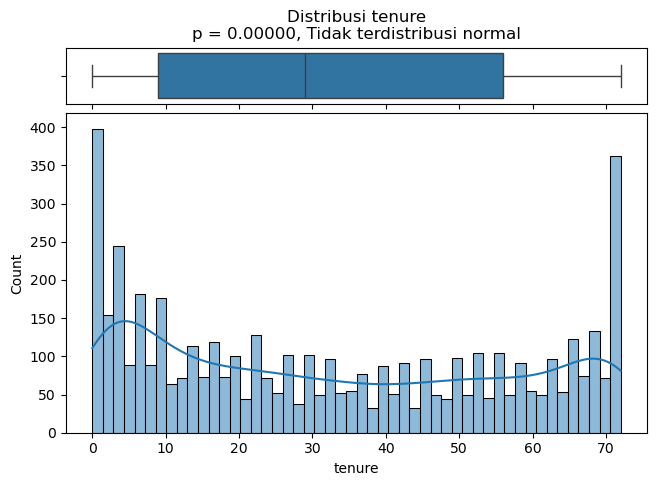

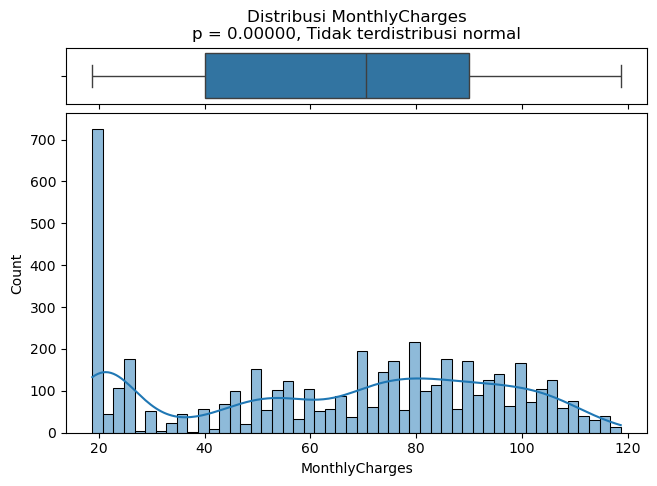

In [25]:
for col in numeric_cols_var:
    data = df[col]

    stat, p = normaltest(data)
    if p > 0.05:
        distribusi = f'p = {p:.5f}, Distribusi Normal'
    else:
        distribusi = f'p = {p:.5f}, Tidak terdistribusi normal'
    
    fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (7.5,5), gridspec_kw={'height_ratios': (.15, .85), 'hspace': 0.05})
    ax1.set_title(f'Distribusi {col}\n{distribusi}')
    sns.boxplot(x = df[col], ax = ax1)
    ax1.set(xlabel = '')
    sns.histplot(data = df[col], ax = ax2, stat = 'count', kde=True, bins=50)
    plt.show()

- Kedua fitur numerik tidak terdistribusi normal.
- Dapat dilihat dari boxplot tidak terdapat outlier sehingga sesuai dengan pengecekan outlier sebelumnya.

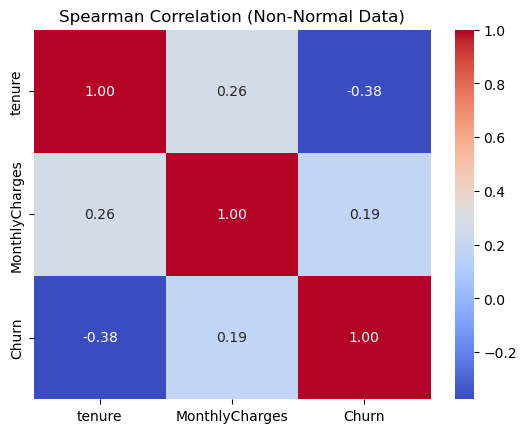

In [26]:
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

corr_spearman = df[numerical_columns].corr(method='spearman')

sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Spearman Correlation (Non-Normal Data)')
plt.show()

- Tidak terdapat korelasi tinggi antar features numerik artinya multikolinearitas dan redundansi antar features numerik juga tidak ditemui.
- Korelasi features numerik dengan target rendah artinya tidak ada fitur yang terlalu jelas hubungannya dengan target.
- Oleh karena itu, seluruh features numerik tetap digunakan.

## Features Engineering

In [27]:
dataDesc = []
for i in df.columns:
    dataDesc.append([
        i,
        df[i].nunique(),
        df[i].unique()
    ])

pd.set_option('max_colwidth', None)

pd.DataFrame(dataDesc, columns=[
    'Data Features',
    'Unique',
    'Unique Sample'
])

,Data Features,Unique,Unique Sample
0,Dependents,2,"[Yes, No]"
1,tenure,73,"[9, 14, 64, 72, 3, 40, 17, 11, 8, 47, 18, 5, 1, 48, 13, 58, 7, 4, 70, 34, 31, 37, 15, 71, 10, 43, 22, 33, 69, 54, 63, 55, 66, 56, 32, 26, 24, 2, 51, 23, 49, 28, 36, 45, 42, 6, 61, 59, 67, 65, 0, 16, 52, 41, 25, 62, 20, 50, 30, 60, 19, 35, 57, 27, 44, 53, 12, 46, 39, 29, 38, 68, 21]"
2,OnlineSecurity,2,"[No, Yes]"
3,OnlineBackup,2,"[No, Yes]"
4,InternetService,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,2,"[Yes, No]"
6,TechSupport,2,"[Yes, No]"
7,Contract,3,"[Month-to-month, Two year, One year]"
8,PaperlessBilling,2,"[Yes, No]"
9,MonthlyCharges,1422,"[72.9, 82.65, 47.85, 69.65, 23.6, 74.55, 19.7, 44.05, 73.5, 40.3, 33.6, 96.25, 70.45, 30.55, 44.8, 20.0, 81.5, 94.35, 35.3, 50.7, 106.05, 56.3, 20.65, 98.9, 40.2, 81.2, 19.45, 116.1, 55.2, 94.45, 84.85, 19.6, 79.0, 74.7, 30.4, 55.8, 104.5, 70.55, 55.25, 96.65, 88.85, 109.25, 104.75, 74.4, 79.4, 74.1, 73.05, 94.6, 70.35, 79.6, 79.5, 90.7, 81.0, 87.75, 118.65, 24.8, 105.25, 57.8, 19.0, 25.7, 54.2, 44.85, 19.95, 81.05, 20.35, 85.25, 67.45, 100.3, 20.95, 105.2, 26.35, 82.15, 102.6, 106.15, 23.95, 115.8, 66.85, 90.35, 89.85, 73.35, 104.45, 35.45, 88.4, 70.5, 25.1, 39.0, 83.25, 74.3, 54.3, 50.45, 86.0, 19.55, 103.5, 91.7, 64.85, 99.65, 68.75, 106.25, 75.9, 94.4, ...]"


In [28]:
binary_cols = ['Dependents','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','PaperlessBilling']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

Digunakan label encoding untuk kolom dengan nilai biner.

In [29]:
num_cols = ['tenure', 'MonthlyCharges']
ordinal_categories = [['Month-to-month', 'One year', 'Two year']]

transformer_scaled = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['InternetService']),
    ('binary', 'passthrough', binary_cols),
    ('ordinal', OrdinalEncoder(categories=ordinal_categories), ['Contract']),
    ('num', StandardScaler(), num_cols)
])

transformer_no_scale = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['InternetService']),
    ('binary', 'passthrough', binary_cols),
    ('ordinal', OrdinalEncoder(categories=ordinal_categories), ['Contract']),
    ('num', 'passthrough', num_cols)
])

- One-Hot Encoding untuk InternetService karena nilainya nominal dan bukan biner.
- Label Encoding dengan OrdinalEncoder untuk Contract karena merupakan urutan.
- Dikarenakan tidak terdapat outlier di fitur numerik maka digunakan StandardScaler untuk model yang membutuhkan scaling yaitu Logistic Regression dan KNN.

## Modelling

### Split Data

In [30]:
X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Model Benchmarking
- Digunakan Recall Kelas 1 untuk memilih model awal sebelum handling imbalance dan hyperparameter tuning.
- Model diharapkan mengurangi false negative dari pelanggan yang churn.

#### Model Benchmarking: Train Data

In [31]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

In [32]:
models = [logreg, knn, dt, rf, xgb, lgbm]
score = []
rata2 = []
std = []

skfold = StratifiedKFold(n_splits=5)

for model in models:
    if model in [logreg, knn]:
        transformer = transformer_scaled
    else:
        transformer = transformer_no_scale
        
    pipeline = Pipeline([
        ('preprocess', transformer),
        ('model', model)
    ])
    
    model_cv = cross_val_score(pipeline, X_train, y_train, cv=skfold, scoring='recall')
    score.append(model_cv)
    rata2.append(model_cv.mean())
    std.append(model_cv.std())

df_cv_train = pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
                            'train mean recall':rata2,
                            'train sdev':std}
                          ).set_index('model').sort_values(by='train mean recall',ascending=False)
df_cv_train

[LightGBM] [Info] Number of positive: 824, number of negative: 2281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 3105, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265378 -> initscore=-1.018199
[LightGBM] [Info] Start training from score -1.018199
[LightGBM] [Info] Number of positive: 824, number of negative: 2281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 3105, number of used features: 11
[LightGBM] [Info] [binary:Bo

,train mean recall,train sdev
model,,
KNN,0.523301,0.027011
Logistic Regression,0.518447,0.048776
LightGBM,0.499029,0.012048
XGBoost,0.499029,0.032838
Decision Tree,0.479612,0.035725
Random Forest,0.470874,0.040382


KKN model terbaik pada train data dengan mean recall tertinggi dan standar deviasi cukup kecil.

#### Model Benchmarking: Test Data

In [33]:
recall_test = []

for model in models:
    if model in [logreg, knn]:
        transformer = transformer_scaled
    else:
        transformer = transformer_no_scale
        
    pipeline = Pipeline([
        ('preprocess', transformer),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    recall = recall_score(y_test, y_pred, pos_label=1)

    recall_test.append(recall)
    
df_cv_test = pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
                            'test recall':recall_test}
                          ).set_index('model').sort_values(by='test recall',ascending=False)

df_cv_test

[LightGBM] [Info] Number of positive: 1030, number of negative: 2852
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 3882, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265327 -> initscore=-1.018462
[LightGBM] [Info] Start training from score -1.018462


,test recall
model,
Logistic Regression,0.538760
XGBoost,0.507752
LightGBM,0.500000
Decision Tree,0.488372
KNN,0.457364
Random Forest,0.399225


Logistic Regression model terbaik pada test data dengan recall tertinggi.

In [34]:
df_cv = pd.merge(df_cv_train, df_cv_test, on='model')
df_cv = df_cv.sort_values(by='test recall', ascending=False)

df_cv

,train mean recall,train sdev,test recall
model,,,
Logistic Regression,0.518447,0.048776,0.538760
XGBoost,0.499029,0.032838,0.507752
LightGBM,0.499029,0.012048,0.500000
Decision Tree,0.479612,0.035725,0.488372
KNN,0.523301,0.027011,0.457364
Random Forest,0.470874,0.040382,0.399225


- Logistic Regression memiliki recall test lebih tinggi daripada train artinya indikasi tidak overfit.
- Model Logistic Regression juga konsisten kedua tertinggi di train dan tertinggi di test.
- Oleh karena itu, selanjutnya digunakan Logistic Regression dan melakukan handling imbalance dan hyperparameter tuning.
- Ini dilakukan untuk mengetahui hasil terbaik dari model Logistic Regression.

### Cara Kerja Logistic Regression
Logistic regression merupakan metode statistik untuk memprediksi kejadian biner. Metode ini dapat mencakup hanya satu maupun beberapa variabel independen. Model ini meprediksi kemungkinan dari suatu kejadian dengan persamaan:
$$ \text{Probability of outcome}(\hat{Y_i}) = \frac{e^{\beta_0+\beta_1 X_1+\beta_2 X_2+...+\beta_i X_i}}{1 + e^{\beta_0+\beta_1 X_1+\beta_2 X_2+...+\beta_i X_i}} $$
- $\hat{Y_i}$ merepresentasikan estimasi probabilitas yang ada dalam satu kategori hasil biner (i) versus kategori lainnya.
- Persamaan $e^{\beta_0+\beta_1 X_1+\beta_2 X_2+...+\beta_i X_i}$ merupakan persamaan regresi linier untuk variabel independen yang dinyatakan dalam skala logit.

Transformasi skala logit ini dilakukan karena hasil dari model yang biner dinyatakan sebagai probabilitas dengan nilai antara 0 dan 1. Di sisi lain, variabel independen nilainya dapat berupa bilangan apapun sehingga skala logit dibutuhkan dalam perbedaan jenis bilangan ini. Hubungan hasil dan variabel independen ditunjukkan persamaan berikut:
$$ \ln(\frac{\hat{Y}}{1 - \hat{Y}}) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_i X_i $$

Sumber: https://onlinelibrary.wiley.com/doi/full/10.1111/j.1553-2712.2011.01185.x

### Handling Imbalance

In [35]:
def Eva_metrics_base_class(model, X_train, X_test, y_train, y_test, Nama, fit=False):
    if fit == False:
        Model = model.fit(X_train, y_train)
    else:
        Model = model
    y_pred_train = Model.predict(X_train)
    Acc_train = accuracy_score(y_train, y_pred_train)
    Rec_train = recall_score(y_train, y_pred_train)
    Prec_train = precision_score(y_train, y_pred_train)
    F1_train = f1_score(y_train, y_pred_train)
    
    y_pred_test = Model.predict(X_test)
    Acc_test = accuracy_score(y_test, y_pred_test)
    Rec_test = recall_score(y_test, y_pred_test)
    Prec_test = precision_score(y_test, y_pred_test)
    F1_test = f1_score(y_test, y_pred_test)
    
    data = {
        Nama + ' Training' : [Acc_train, Rec_train, Prec_train, F1_train],
        Nama + ' Testing' : [Acc_test, Rec_test, Prec_test, F1_test]
    }
    df = pd.DataFrame(data, index=['Accuracy', 'Recall', 'Precision', 'F1'])
    
    cr_tr = classification_report(y_train, y_pred_train)
    cm_tr = confusion_matrix(y_train, y_pred_train, labels=[1, 0])
    df_tr = pd. DataFrame(data=cm_tr, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0' ])
    
    cr_ts = classification_report(y_test, y_pred_test)
    cm_ts = confusion_matrix(y_test, y_pred_test, labels=[1, 0])
    df_ts = pd. DataFrame(data=cm_ts, columns=['Pred 1', 'Pred 0'], index=[ 'Akt 1', 'Akt 0'])
    
    return df, cr_tr, df_tr, cr_ts, df_ts

#### Logistic Regression (Base)

In [36]:
logreg_plain = LogisticRegression(random_state=42)

pipeline_plain = Pipeline([
    ('preprocess', transformer_scaled),
    ('model', logreg_plain)
])

df_eval, cr_train, cm_train, cr_test, cm_test = Eva_metrics_base_class(
    pipeline_plain,
    X_train, X_test,
    y_train, y_test,
    'Logistic Regression (Base)'
)

#### Logistic Regression (Balanced Class Weight)

In [37]:
logreg_balanced = LogisticRegression(random_state=42, class_weight='balanced')

pipeline_balanced = Pipeline([
    ('preprocess', transformer_scaled),
    ('model', logreg_balanced)
])

df_eval_bal, cr_train_bal, cm_train_bal, cr_test_bal, cm_test_bal = Eva_metrics_base_class(
    pipeline_balanced,
    X_train, X_test,
    y_train, y_test,
    'Logistic Regression (Balanced)'
)

#### Logistic Regression (Random Over Sampling)

In [38]:
logreg_ros = LogisticRegression(random_state=42)

pipeline_ros = ImbPipeline([
    ('preprocess', transformer_scaled),
    ('oversample', RandomOverSampler(random_state=42)),
    ('model', logreg_ros)
])

df_eval_ros, cr_train_ros, cm_train_ros, cr_test_ros, cm_test_ros = Eva_metrics_base_class(
    pipeline_ros,
    X_train, X_test,
    y_train, y_test,
    'Logistic Regression (RandomOverSampler)'
)

#### Logistic Regression (SMOTE)

In [39]:
logreg_smote = LogisticRegression(random_state=42)

pipeline_smote = ImbPipeline([
    ('preprocess', transformer_scaled),
    ('smote', SMOTE(random_state=42)),
    ('model', logreg_smote)
])

df_eval_smote, cr_train_smote, cm_train_smote, cr_test_smote, cm_test_smote = Eva_metrics_base_class(
    pipeline_smote,
    X_train, X_test,
    y_train, y_test,
    'Logistic Regression (SMOTE)'
)

#### Evaluasi Handling Imbalance

In [40]:
df_eval_imb = pd.concat([df_eval, df_eval_bal, df_eval_ros, df_eval_smote], axis=1)
df_eval_imb.T

,Accuracy,Recall,Precision,F1
Logistic Regression (Base) Training,0.795209,0.524272,0.639053,0.576000
Logistic Regression (Base) Testing,0.795057,0.538760,0.634703,0.582809
Logistic Regression (Balanced) Training,0.746265,0.800971,0.514019,0.626186
Logistic Regression (Balanced) Testing,0.745623,0.806202,0.513580,0.627451
Logistic Regression (RandomOverSampler) Training,0.744204,0.801942,0.511455,0.624575
Logistic Regression (RandomOverSampler) Testing,0.747683,0.810078,0.516049,0.630468
Logistic Regression (SMOTE) Training,0.744977,0.790291,0.512594,0.621849
Logistic Regression (SMOTE) Testing,0.746653,0.794574,0.515075,0.625000


- Tidak ada indikasi overfitting karena performa training dan testing sangat dekat.
- Tidak ada indikasi underfitting karena model masih punya performa yang layak (tidak terlalu rendah).
- Model Logistic Regression dengan Imbalance handling sengaja mengorbankan accuracy untuk recall yang lebih tinggi dan ini tercapai dengan baik tanpa overfitting.

In [41]:
df_eval_imb_test = df_eval_imb.T.iloc[1::2].sort_values(by='Recall', ascending=False)
df_eval_imb_test

,Accuracy,Recall,Precision,F1
Logistic Regression (RandomOverSampler) Testing,0.747683,0.810078,0.516049,0.630468
Logistic Regression (Balanced) Testing,0.745623,0.806202,0.513580,0.627451
Logistic Regression (SMOTE) Testing,0.746653,0.794574,0.515075,0.625000
Logistic Regression (Base) Testing,0.795057,0.538760,0.634703,0.582809


- Dikarenakan perusahaan ingin mendeteksi sebanyak mungkin pelanggan yang churn maka recall kelas 1 menjadi fokus dari model.
- Model Logistic Regression dengan Imbalance handling memiliki recall kelas 1 yang lebih tinggi dari base model.
- Ketiga metode Imbalance handling memiliki recall kelas 1 yang hampir sama dengan nilai tertinggi pada metode Random Over Sampling.
- Dikarenakan kemiripan recall kelas 1 dari ketiga metode Imbalance handling , hyperparameter tuning akan dilakukan untuk mengetahui yang terbaik.

### Hyperparameter Tuning

In [42]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logreg = LogisticRegression(random_state=42)

pipe_balanced = Pipeline([
    ('preprocess', transformer_scaled),
    ('model', LogisticRegression(random_state=42, class_weight='balanced'))
])

params_balanced = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs']
}

pipe_ros = ImbPipeline([
    ('preprocess', transformer_scaled),
    ('oversample', RandomOverSampler(random_state=42)),
    ('model', logreg)
])

params_ros = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs']
}

pipe_smote = ImbPipeline([
    ('preprocess', transformer_scaled),
    ('oversample', SMOTE(random_state=42)),
    ('model', logreg)
])

params_smote = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs']
}

def run_grid_search(pipe, params, X_train, y_train, label):
    print(f'GridSearchCV untuk {label}...')
    gs = GridSearchCV(pipe, param_grid=params, cv=skfold, scoring='recall', n_jobs=-1)
    gs.fit(X_train, y_train)
    print(f'Best params: {gs.best_params_}')
    print(f'Best CV recall: {gs.best_score_:.4f}\n')
    return gs.best_estimator_

balanced_tuning = run_grid_search(pipe_balanced, params_balanced, X_train, y_train, 'class_weight balanced')
ros_tuning = run_grid_search(pipe_ros, params_ros, X_train, y_train, 'RandomOverSampler')
smote_tuning = run_grid_search(pipe_smote, params_smote, X_train, y_train, 'SMOTE')

GridSearchCV untuk class_weight balanced...
Best params: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV recall: 0.8097

GridSearchCV untuk RandomOverSampler...
Best params: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV recall: 0.8087

GridSearchCV untuk SMOTE...
Best params: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV recall: 0.8010



- model__C: Ini adalah parameter regularisasi di Logistic Regression.
  - Nilai C adalah inverse dari strength regularization.
  - Nilai kecil regularisasinya kuat artinya model lebih sederhana dan mengurangi overfitting.
  - Nilai besar regularisasinya lemah artinya model lebih fleksibel.
  - Dicoba beberapa nilai agar ditemukan trade-off terbaik antara bias dan variance.
- model__penalty: Penalti regularisasi yang dipakai adalah L2 (Ridge) yang merupakan standar dan umum untuk Logistic Regression.
- model__solver: lbfgs solver merupakan algoritma optimisasi untuk fitting Logistic Regression yang bagus untuk L2 penalty.
- Ketiga metode imbalance handling mendapatkan hyperparameter terbaik yang sama yaitu dengan model__C 0.01.

In [43]:
df_eval_bal_tuned, cr_train_bal_tuned, cm_train_bal_tuned, cr_test_bal_tuned, cm_test_smote_tuned = Eva_metrics_base_class(
    balanced_tuning,
    X_train, X_test,
    y_train, y_test,
    'Logistic Regression (Balanced Tuned)',
    True
)

df_eval_ros_tuned, cr_train_ros_tuned, cm_train_ros_tuned, cr_test_ros_tuned, cm_test_smote_tuned = Eva_metrics_base_class(
    ros_tuning,
    X_train, X_test,
    y_train, y_test,
    'Logistic Regression (RandomOverSampler Tuned)',
    True
)

df_eval_smote_tuned, cr_train_smote_tuned, cm_train_smote_tuned, cr_test_smote_tuned, cm_test_smote_tuned = Eva_metrics_base_class(
    smote_tuning,
    X_train, X_test,
    y_train, y_test,
    'Logistic Regression (SMOTE Tuned)',
    True
)

#### Evaluasi Hyperparameter Tuning

In [44]:
df_eval_tun = pd.concat([df_eval_bal, df_eval_ros, df_eval_smote, df_eval_bal_tuned, df_eval_ros_tuned, df_eval_smote_tuned], axis=1)
df_eval_tun.T

,Accuracy,Recall,Precision,F1
Logistic Regression (Balanced) Training,0.746265,0.800971,0.514019,0.626186
Logistic Regression (Balanced) Testing,0.745623,0.806202,0.513580,0.627451
Logistic Regression (RandomOverSampler) Training,0.744204,0.801942,0.511455,0.624575
Logistic Regression (RandomOverSampler) Testing,0.747683,0.810078,0.516049,0.630468
Logistic Regression (SMOTE) Training,0.744977,0.790291,0.512594,0.621849
Logistic Regression (SMOTE) Testing,0.746653,0.794574,0.515075,0.625000
Logistic Regression (Balanced Tuned) Training,0.740082,0.811650,0.506360,0.623648
Logistic Regression (Balanced Tuned) Testing,0.750772,0.833333,0.519324,0.639881
Logistic Regression (RandomOverSampler Tuned) Training,0.739310,0.809709,0.505455,0.622388
Logistic Regression (RandomOverSampler Tuned) Testing,0.748713,0.829457,0.516908,0.636905


- Tidak ada indikasi overfitting karena performa training dan testing sangat mirip di semua metrik dan model.
- Tidak ada indikasi underfitting karena model masih punya performa yang layak (tidak terlalu rendah).
- Model dengan tuning menunjukkan peningkatan performa testing artinya tuning efektif.

In [45]:
df_eval_tun_test = df_eval_tun.T.iloc[1::2].sort_values(by='Recall', ascending=False)
df_eval_tun_test

,Accuracy,Recall,Precision,F1
Logistic Regression (Balanced Tuned) Testing,0.750772,0.833333,0.519324,0.639881
Logistic Regression (RandomOverSampler Tuned) Testing,0.748713,0.829457,0.516908,0.636905
Logistic Regression (SMOTE Tuned) Testing,0.750772,0.825581,0.519512,0.637725
Logistic Regression (RandomOverSampler) Testing,0.747683,0.810078,0.516049,0.630468
Logistic Regression (Balanced) Testing,0.745623,0.806202,0.513580,0.627451
Logistic Regression (SMOTE) Testing,0.746653,0.794574,0.515075,0.625000


- Recall kelas 1 naik setelah dilakukan hyperparameter tuning.
- Handling imbalance dan tuning membantu meningkatkan recall kelas 1.
- Logistic Regression dengan balanced class weight dan hyperparameter tuning menjadi model terbaik karena memiliki recall kelas 1 tertinggi.

#### Evaluasi Model Logistic Regression dengan Balanced Class Weight dan Hyperparameter Tuning

In [46]:
print('Classification Report:')
print(cr_test_bal_tuned)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       713
           1       0.52      0.83      0.64       258

    accuracy                           0.75       971
   macro avg       0.72      0.78      0.72       971
weighted avg       0.82      0.75      0.76       971



- Model sangat baik dalam mengidentifikasi pelanggan yang churn (recall 0.83) ini penting untuk bisnis agar dapat mengambil tindakan preventif.
- Model menghasilkan cukup banyak false positives (precision 0.52 pada churn) artinya ada risiko memperingatkan pelanggan yang sebenarnya tidak akan churn.
- Trade-off ini umum pada masalah imbalance dan business context yang mengutamakan recall kelas 1 agar tidak kehilangan pelanggan yang benar-benar akan berhenti.

### Feature Importances

In [47]:
preprocessor = balanced_tuning.named_steps['preprocess']

onehot = preprocessor.named_transformers_['onehot']
onehot_feature_names = onehot.get_feature_names_out(['InternetService'])

binary_features = binary_cols

ordinal_features = ['Contract']

num_features = num_cols

all_features = list(onehot_feature_names) + binary_features + ordinal_features + num_features

coef = balanced_tuning.named_steps['model'].coef_.flatten()

coef_df = pd.DataFrame({
    'feature': all_features,
    'coefficient': coef
})

coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

coef_df

,feature,coefficient,abs_coef
8,Contract,-0.704488,0.704488
9,tenure,-0.644418,0.644418
10,MonthlyCharges,0.436337,0.436337
0,InternetService_Fiber optic,0.360612,0.360612
1,InternetService_No,-0.311471,0.311471
3,OnlineSecurity,-0.310633,0.310633
7,PaperlessBilling,0.290045,0.290045
6,TechSupport,-0.239228,0.239228
2,Dependents,-0.183699,0.183699
4,OnlineBackup,-0.125507,0.125507


- Fitur dengan koefisien negatif mengurangi risiko churn.
- Fitur dengan koefisien positif meningkatkan risiko churn.
- Nilai negatif pada fitur ordinal Contract artinya semakin lama kontrak maka risiko pelanggan churn turun.
- tenure merupakan fitur numerik dengan nilai koefisien negatif artinya semakin loyal pelanggan maka kemungkinan churn berkurang.
- Fitur numerik MonthlyCharges dengan nilai koefisien positif artinya artinya biaya bulanan lebih tinggi meningkatkan kemungkinan churn.
- InternetService_Fiber optic dan InternetService_No adalah hasil one-hot encoding dari InternetService dengan baseline kategori yang di-drop yaitu InternetService_DSL.
  - Koefisien positif untuk Fiber optic artinya jika pelanggan menggunakan layanan Fiber optic dibanding baseline risiko churnnya cenderung naik.
  - Koefisien negatif untuk pelanggan yang tidak menggunakan layanan internet artinya pelanggan jenis ini dibanding baseline risiko churnnya cenderung turun.
- Fitur binary PaperlessBilling memiliki koefisien positif artinya pelanggan dengan billing tanpa kertas cenderung lebih berisiko churn.
- Fitur binary selain PaperlessBilling dengan koef negatif artinya jika nilainya Yes kemungkinan churn menurun.

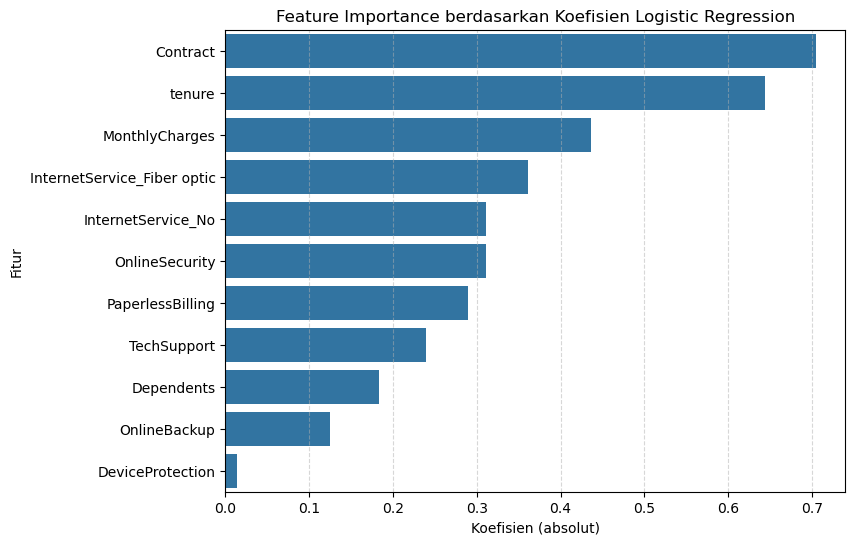

In [48]:
plt.figure(figsize=(8,6))
sns.barplot(x='abs_coef', y='feature', data=coef_df)
plt.title('Feature Importance berdasarkan Koefisien Logistic Regression')
plt.xlabel('Koefisien (absolut)')
plt.ylabel('Fitur')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

In [49]:
internet_features = coef_df[coef_df['feature'].str.startswith('InternetService')]

total_internet_importance = internet_features['abs_coef'].sum()

print(f"Total pengaruh fitur InternetService (jumlah abs_coef): {total_internet_importance}")

Total pengaruh fitur InternetService (jumlah abs_coef): 0.6720831252711544


- Apabila dilihat dari bar chart, fitur Contract, tenure, dan MonthlyCharges adalah yang paling berpengaruh.
- Namun perlu diingat bahwa InternetService merupakan fitur dengan nilai nominal sehingga pengaruhnya ditentukan dari jumlah nilai absolut koefisien InternetService_Fiber optic dan InternetService_No.
- Pengaruh fitur InternetService adalah 0.672083 artinya lebih besar dari koefisien absolut tenure.
- Oleh karena itu 4 fitur paling berpengaruh adalah Contract, InternetService, tenure, dan MonthlyCharge.

## Conclusion and Recommendation

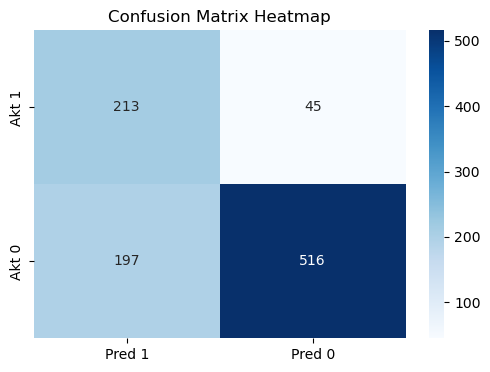

In [50]:
plt.figure(figsize=(6,4))
sns.heatmap(cm_test_smote_tuned, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.show()

### Kesimpulan
- Model terbaik yaitu logistic regression dengan balanced class weight dan hyperparameter tuning yang dapat memprediksi 83% pelanggan yang churn dengan presisi 52%.
  - Dari [artikel](https://pmc.ncbi.nlm.nih.gov/articles/PMC10239051/?utm_source=chatgpt.com) didapati informasi bahwa mendapatkan pelanggan baru bisa 5–25 kali lebih mahal dibanding mempertahankan pelanggan yang sudah ada.
  - Misalkan biaya mempertahankan 1 dollar per orang dan biaya dan biaya mendapatkan pelanggan baru 5 dollar per orang ini menggunakan 5 yang merupakan kelipatan terkecil.
  - Tanpa model:
    - False positive  $\frac{258}{971}\times 713$ yaitu 189 artinya kerugian 189 dollar.
    - False negative  $\frac{713}{971}\times 258$ yaitu 189 artinya kerugian 945 dollar.
    - Total Kerugian 1134 dollar.
  - Dengan model:
    - Kerugian dari false positive (197) karena salah sasaran adalah 197 dollar dan false negative (45) karena gagal prediksi 225 dollar.
    - Total kerugian 422 dollar.
  - Berdasarkan pengandaian didapati bahwa penggunaan model dapat mengurangi kerugian hingga 62.79%.
- Fitur yang paling berpengaruh adalah Contract, InternetService, tenure, dan MonthlyCharge.
- Limitasi model:

| Fitur | Tipe Data | Limitasi |
| --- | --- | --- |
| Dependents | Object | Nilai unik: 'Yes', 'No' |
| tenure | Integer | Rentang 0 - 72 bulan |
| OnlineSecurity | Object | Nilai unik: 'Yes', 'No', 'No internet service' |
| OnlineBackup | Object | Nilai unik: 'Yes', 'No', 'No internet service' |
| InternetService | Object | Nilai unik: 'DSL', 'Fiber optic', 'No' |
| DeviceProtection | Object | Nilai unik: 'Yes', 'No', 'No internet service' |
| TechSupport | Object | Nilai unik: 'Yes', 'No', 'No internet service' |
| Contract | Object | Nilai unik: 'Month-to-month', 'Two year', 'One year' |
| Paperlessbilling | Object | Nilai unik: 'Yes', 'No' |
| MonthlyCharges | Float | Rentang 18.8-118.65 (biaya bulanan) |
| Churn | Object | Nilai unik: 'Yes', 'No' |

### Rekomendasi
Berikut rekomendasi untuk meningkatkan performa model agar dapat bekerja lebih baik:
- Peningkatan Data
  - Integrasi Data Eksternal: Tambahkan data dari sumber lain seperti log interaksi customer service (durasi panggilan, jumlah keluhan) atau data media sosial.
- Peningkatan Performa dan Strategi Model
  - Sesuaikan model untuk meminimalkan kerugian finansial, bukan hanya kesalahan prediksi. Gunakan teknik cost-sensitive learning dengan memberikan bobot lebih besar pada pelanggan yang churn tapi tidak terdeteksi.
  - Mencoba metode imbalance handling selain Random Over Sampling, SMOTE, dan Balanced Class Weight pada model logistic regression.
  - Mencoba model machine learning lain dengan disertai hyperparameter tuning dan imbalance handling.
- Implementasi dan Penerapan Bisnis
  - Automatisasi Proses dengan membangun pipeline otomatis untuk memprediksi churn secara berkala dan memperbarui model.
  - Uji Coba A/B yang dilakukan dengan menerapkan model ini pada kelompok uji untuk mengukur efektivitasnya dalam mengurangi churn secara empiris. Kemudian, bandingkan hasilnya dengan kelompok kontrol.
  - Membuat dashboard yang dapat digunakan oleh tim bisnis (marketing/customer service) untuk melihat dan mengambil tindakan proaktif pada pelanggan yang diprediksi akan churn.

## Save Model

In [51]:
# with open('final_model.pkl', 'wb') as f:
#     pickle.dump(balanced_tuning, f)

# print('Model berhasil disimpan ke final_model.pkl')

In [52]:
# with open('final_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# y_pred = loaded_model.predict(X_test)

# cr_loaded = classification_report(y_test, y_pred)

# print(cr_loaded)